# Build a Simple Workflow or Graph Using LangGraph

**State**
First, define the State of the graph.

The State schema serves as the input schema for all Nodes and Edges in the graph.

Let's use the TypedDict class from python's typing module as our schema, which provides type hints for the keys.

In [6]:
from typing_extensions import TypedDict
class State(TypedDict):
    graph_info:str

## Nodes
Nodes are just python functions.

The first positional argument is the state, as defined above.

Because the state is a TypedDict with schema as defined above, each node can access the key, graph_state, with state['graph_state'].

Each node returns a new value of the state key graph_state.

By default, the new value returned by each node will override the prior state value.

In [7]:
def start_play(state:State):
    print("Start_Play node has been called")
    return {"graph_info":state['graph_info'] + " I am planning to play"}

def cricket(state:State):
    print("My Cricket node has been called")
    return {"graph_info":state['graph_info'] + " Cricket"}

def badminton(state:State):
    print("My badminton node has been called")
    return {"graph_info":state['graph_info'] + " Badminton"}

In [8]:
import random
from typing import Literal

def random_play(state:State)-> Literal['cricket','badminton']:
    graph_info=state['graph_info']

    if random.random()>0.5:
        return "cricket"
    else:
        return "badminton"

## Graph Construction
Now, we build the graph from our components defined above.

The StateGraph class is the graph class that we can use.

First, we initialize a StateGraph with the State class we defined above.

Then, we add our nodes and edges.

We use the START Node, a special node that sends user input to the graph, to indicate where to start our graph.

The END Node is a special node that represents a terminal node.

Finally, we compile our graph to perform a few basic checks on the graph structure.

We can visualize the graph as a Mermaid diagram.

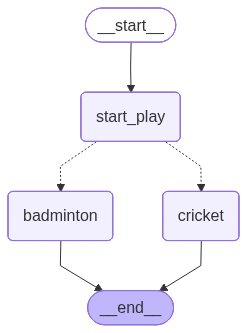

In [9]:
from IPython.display import Image,display
from langgraph.graph import StateGraph,START,END

## Build Graph
graph=StateGraph(State)

## Adding the nodes
graph.add_node("start_play",start_play)
graph.add_node("cricket",cricket)
graph.add_node("badminton",badminton)

## Schedule the flow of the graph

graph.add_edge(START,"start_play")
graph.add_conditional_edges("start_play",random_play)
graph.add_edge("cricket",END)
graph.add_edge("badminton",END)

## Compile the graph
graph_builder=graph.compile()

## View
display(Image(graph_builder.get_graph().draw_mermaid_png()))

### GRAPH Invocation

In [10]:
graph_builder.invoke({"graph_info":"Hey My name is Krish"})

Start_Play node has been called
My Cricket node has been called


{'graph_info': 'Hey My name is Krish I am planning to play Cricket'}

## **Notes**

## **Introduction to LangGraph**

LangGraph is an evolution of the LangChain framework that brings **graph-based orchestration** to large language model (LLM) workflows. It allows developers to design **modular, dynamic, and stateful AI applications** using a **node-and-edge execution model**, enabling more control, flexibility, and reliability compared to traditional linear chain structures.

**What is LangGraph?**

**LangGraph** is a **graph-based framework** built on top of LangChain that enables you to define and execute **complex, multi-agent or multi-step reasoning workflows** using **directed graphs**.

Each **node** represents a computation (such as an LLM call, retriever, or custom function), and **edges** define the **flow of execution** between nodes.

LangGraph gives developers fine-grained control over:

* How data flows between steps.
* When nodes execute (based on conditions or events).
* How to handle state and memory across a long conversation or computation.

LangGraph can be thought of as **“LangChain + Graph Execution + Persistent State”**, making it ideal for **RAG pipelines, autonomous agents, and decision-driven reasoning systems.**

---

**The Motivation Behind LangGraph**

LangChain’s **Sequential Chains** and **Agent Executors** are powerful but limited:

* They assume a **linear execution flow**.
* Handling **branching logic**, **loops**, or **stateful agents** requires complex custom code.
* Scaling to multi-agent workflows or conditional execution becomes cumbersome.

LangGraph solves these challenges by introducing a **graph execution engine** that allows:

1. **Conditional routing** – e.g., if the model is unsure, send the query to a secondary verifier.
2. **Parallel execution** – run multiple LLMs or retrievers simultaneously.
3. **Persistent state management** – carry context across multiple graph steps or sessions.
4. **Event-based orchestration** – trigger actions based on model responses or external inputs.

In short, LangGraph gives developers **a declarative way to design LLM applications** that resemble **workflow engines** more than simple pipelines.

---

**LangChain vs. LangGraph**

| Feature                | **LangChain**                      | **LangGraph**                                   |
| ---------------------- | ---------------------------------- | ----------------------------------------------- |
| **Execution Model**    | Linear or nested chains            | Directed graph with nodes and edges             |
| **State Management**   | Transient (limited to memory type) | Persistent and shared across nodes              |
| **Branching Logic**    | Hard-coded                         | Natively supported                              |
| **Concurrency**        | Sequential                         | Parallel or asynchronous                        |
| **Complexity**         | Best for simple pipelines          | Best for dynamic, multi-agent systems           |
| **Use Case Example**   | Question answering, summarization  | Multi-step reasoning, RAG + planning agents     |
| **Memory Integration** | Local or chain-level               | Global graph memory with node-level updates     |
| **Error Handling**     | Manual                             | Built-in retries, fallbacks, and event triggers |

LangGraph doesn’t replace LangChain — it extends it.
You still use **LangChain components** (like `LLMChain`, `Retrievers`, `PromptTemplates`, etc.) inside LangGraph **nodes**. The difference is **how you connect and execute** them.

---

**Real-World Applications and Use Cases**

LangGraph is designed for **complex AI systems** where linear execution isn’t enough.

1. **Autonomous Multi-Agent Systems**

* Multiple agents collaborate and share state via the graph.
* Example: Researcher agent → Retriever agent → Summarizer agent → Evaluator agent.

2. **Dynamic RAG Pipelines**

* Different retrieval or reasoning paths triggered by query type.
* Example: Technical query → Documentation retriever; General query → Knowledge summarizer.

3. **Customer Support Bots**

* Manage long conversations with context, decision points, and fallbacks.
* Example: “Escalate to human” branch when confidence < threshold.

4. **Workflow Automation**

* Combine LLM reasoning with API calls, database queries, and conditional logic.
* Example: Query → Generate SQL → Run Query → Explain Results.

5. **Multi-Modal and Multi-Model Systems**

* Integrate text, image, or code models in one orchestrated graph.
* Example: CLIP-based image retrieval → LLM-based captioning → Summarization.

---
**Core Concepts**

LangGraph introduces several new primitives for graph-based reasoning.

**Nodes**

A **node** is a discrete unit of computation. It can represent:

* An LLM call (`ChatOpenAI`, `ChatAnthropic`)
* A tool or API call
* A retriever or database query
* A custom Python function

Each node can receive **inputs** and produce **outputs**, which are passed through edges to other nodes.

```python
from langgraph.graph import Node

def summarize_text(inputs):
    return {"summary": f"Summary: {inputs['text'][:100]}..."}

summary_node = Node(name="summarizer", func=summarize_text)
```



**Edges**

Edges connect nodes and define how outputs from one node become inputs to the next.
Edges can include **conditions**, allowing for **dynamic branching**.

```python
graph.add_edge("retriever", "generator", condition=lambda x: len(x['docs']) > 0)
```

Edges are what transform LangGraph from a simple chain into a **decision-capable network**.



**Graph Execution**

Graphs are executed by a **GraphExecutor**, which manages:

* Node dependencies
* Execution order
* Parallelism
* State propagation

```python
from langgraph.graph import Graph

graph = Graph()
graph.add_node("retriever", retriever_node)
graph.add_node("generator", generator_node)
graph.add_edge("retriever", "generator")

result = graph.run({"query": "Explain LangGraph"})
```

---

**State Management and Transitions**

LangGraph introduces a **shared state store**, where nodes can:

* Read and update state variables.
* Retain context between executions.
* Transition state based on events (e.g., user input or model output).

This allows for **persistent reasoning**, where an agent can “remember” facts or past interactions across multiple runs.

```python
state.update({"conversation_history": new_messages})
```

State transitions define **when and how the graph moves forward** — essential for **multi-turn dialogues** or **multi-step reasoning**.

---

**Graph Memory vs. LangChain Memory**

| Feature          | **LangChain Memory**              | **LangGraph Memory**                                  |
| ---------------- | --------------------------------- | ----------------------------------------------------- |
| **Scope**        | Per-chain or per-agent            | Global across the graph                               |
| **Persistence**  | Typically in-memory               | Can be persisted (e.g., Redis, Chroma)                |
| **Usage**        | Short-term conversational context | Full state persistence and coordination               |
| **Granularity**  | Tracks messages                   | Tracks variables, documents, and intermediate results |
| **Applications** | Chatbots                          | Multi-agent RAG systems, workflows                    |

LangGraph’s **graph memory** is more structured and long-lived, making it ideal for **autonomous systems** that evolve state over time.

---

**Event-Driven Architecture**

LangGraph supports an **event-driven model**, allowing external triggers or node outputs to **fire specific actions or transitions** in the graph.

Event Types:

* **On Node Success / Failure** → Trigger retries or alternate paths.
* **On User Input** → Resume paused graph with new context.
* **On Timer / External Event** → Schedule future tasks or agent handoffs.

This event model enables **asynchronous, real-time** agent workflows:

* Example: Agent waits for new data or user response before continuing.
* Example: If retrieval fails, trigger a “search expansion” node automatically.

```python
graph.on_event("no_results", lambda: graph.run({"query": "Rephrase and retry"}))
```

This architecture makes LangGraph suitable for **long-running AI processes** like research pipelines, monitoring agents, and conversational memory systems.

---

**Key Takeaways**

* **LangGraph = LangChain + Graph-Oriented Workflow Engine**
* It introduces **nodes**, **edges**, **graph memory**, and **event-driven execution**.
* Ideal for **multi-agent**, **multi-step**, **stateful**, and **dynamic reasoning pipelines**.
* Provides **parallelism**, **conditional routing**, and **persistent state**, far beyond what linear chains can achieve.
* Perfect for advanced systems such as **multi-model RAGs**, **autonomous research agents**, and **AI orchestration frameworks**.



## **Introduction to Groq**

Groq is a **next-generation AI acceleration platform** designed to deliver **ultra-low latency inference** for large language models (LLMs), deep learning, and data processing workloads. Unlike traditional GPUs or CPUs, Groq uses a **novel architecture** optimized for deterministic, massively parallel computation — enabling **real-time inference** at unmatched speeds and efficiency.

---

**What is Groq?**

Groq is both:

1. A **hardware company** that produces the **GroqChip™** — a tensor-streaming processor built for AI workloads.
2. A **software platform (GroqCloud)** that enables **instant inference-as-a-service**, allowing developers to run models like **Llama, Mistral, and Whisper** directly on Groq hardware with sub-millisecond latency.

Groq’s main focus is **accelerating LLMs and AI inference**, not training. The platform is designed to serve **chatbots, RAG pipelines, autonomous systems, and edge AI** with extremely low latency and high throughput.

---

**The Groq Architecture**

Groq’s architecture is fundamentally different from traditional accelerators:

1. **Tensor Streaming Processor (TSP)**

* The **GroqChip™** is based on a **deterministic, single-core tensor-streaming processor**.
* Unlike GPUs (which use thousands of threads with dynamic scheduling), Groq executes all instructions **in a predictable sequence**, ensuring **zero kernel launch overhead**.
* This design makes Groq ideal for **low-latency inference** rather than high-throughput training.

2. **Dataflow Execution Model**

* Groq uses a **dataflow architecture**, where computations are represented as graphs of operations that “flow” through the processor.
* This allows for **pipeline parallelism** — every stage of computation runs simultaneously on different parts of the chip.

3. **On-Chip Memory and Determinism**

* All memory accesses are **pre-scheduled**, so there are no cache misses or unpredictable stalls.
* This ensures **consistent latency**, making Groq ideal for **real-time systems**.

4. **Linear Scalability**

* Groq chips can be connected in clusters where performance scales **linearly** with the number of chips.
* Ideal for **large-scale inference workloads** across distributed data centers.

---

**Why Groq is Revolutionary**

| Feature               | **Groq**                                    | **GPU (e.g., NVIDIA)**    | **CPU**                 |
| --------------------- | ------------------------------------------- | ------------------------- | ----------------------- |
| **Architecture Type** | Deterministic, single-core tensor streaming | Parallel, thread-based    | General-purpose         |
| **Primary Use Case**  | AI inference                                | AI training + inference   | General computation     |
| **Latency**           | Microseconds–milliseconds                   | Milliseconds–seconds      | High                    |
| **Throughput**        | Consistent and predictable                  | Varies by workload        | Low                     |
| **Scalability**       | Linear                                      | Depends on interconnect   | Moderate                |
| **Power Efficiency**  | High                                        | Moderate                  | Low                     |
| **Programming Model** | Static dataflow graphs                      | Dynamic kernel scheduling | Sequential instructions |

Groq’s **deterministic execution** means that every inference will always take the same amount of time, regardless of system load — a major advantage for **real-time AI** (e.g., conversational agents, RAG pipelines, or trading systems).

---

**Groq Software Stack**

Groq provides a complete developer ecosystem to deploy and scale models efficiently:

1. **Groq Compiler**

* Converts machine learning models into optimized tensor graphs for the GroqChip.
* Performs **graph-level optimizations**, unrolling loops and scheduling tensor operations to eliminate runtime overhead.

2. **Groq API**

* Provides Python and REST interfaces for model deployment.
* Allows developers to connect models directly from Hugging Face or LangChain-based applications.

3. **GroqCloud**

* Groq’s cloud inference platform where you can **run models instantly** without provisioning GPUs.
* Supports models like **Llama 3, Mistral 7B, Whisper, and T5**.
* Offers **streaming inference** for chatbots and RAG (Retrieval-Augmented Generation) applications.

Example usage:

```python
from groq import Groq

client = Groq(api_key="your_api_key")

response = client.chat.completions.create(
    model="llama3-70b-8192",
    messages=[{"role": "user", "content": "Explain Groq in simple terms."}]
)

print(response.choices[0].message.content)
```

This API structure is almost identical to OpenAI’s, making migration frictionless.

---

**Groq in RAG (Retrieval-Augmented Generation)**

Groq accelerates RAG systems by reducing latency in two critical areas:

1. **Vector Search + Retrieval**

   * Rapid retrieval of top-k embeddings from databases like **Pinecone**, **Chroma**, or **FAISS**.
2. **LLM Inference**

   * Instant generation using low-latency models deployed on GroqCloud.

In a LangChain RAG pipeline:

* You can integrate Groq as the LLM backend via the `ChatGroq` wrapper.
* This allows for **real-time conversational RAG**, where user queries, retrieval, and response generation all occur in **milliseconds**.

Example:

```python
from langchain.chat_models import ChatGroq

llm = ChatGroq(model="llama3-70b-8192", api_key="your_groq_api_key")

response = llm.invoke("What are the advantages of Groq over GPUs?")
print(response)
```

This integration can be combined with LangChain **retrievers** and **vector stores** to build ultra-fast RAG systems.

---

**Security and Data Privacy**

* GroqCloud offers **secure API access** with encrypted data transmission.
* No data persistence: input and output are not stored unless explicitly configured.
* Supports **enterprise-grade compliance** for data-sensitive workloads (e.g., healthcare, finance).

---

**Performance Benchmarks**

Groq achieves **sub-millisecond inference latency** for models like:

* **Llama 3 70B** — 30–40 tokens/s per user stream.
* **Whisper** — 50× faster-than-real-time transcription.
* **Mistral 7B** — 80–100 tokens/s with deterministic timing.

This makes Groq ideal for:

* **Conversational AI (chatbots, voice assistants)**
* **Real-time RAG pipelines**
* **Autonomous systems** (robots, trading bots)
* **High-frequency data processing**

---

**Limitations and Challenges**

While Groq is powerful, it’s not a universal solution.

| Limitation                   | Explanation                                                                                                   |
| ---------------------------- | ------------------------------------------------------------------------------------------------------------- |
| **Model Support**            | Limited to supported transformer architectures (e.g., Llama, Mistral). Custom models may need re-compilation. |
| **Not for Training**         | Groq is optimized for **inference only**; training still requires GPUs or TPUs.                               |
| **Static Graph Requirement** | Models must be compiled into a fixed computation graph, reducing flexibility for dynamic shapes.              |
| **Cloud-Centric**            | On-premises deployment options are currently limited.                                                         |
| **Ecosystem Maturity**       | Compared to CUDA, developer tools and community support are still growing.                                    |

---

**Real-World Applications**

1. **Conversational Agents** — Sub-millisecond response chatbots powered by Llama 3.
2. **Streaming RAG Systems** — Real-time document retrieval and reasoning pipelines.
3. **Autonomous Vehicles / Edge AI** — Deterministic execution for critical decision systems.
4. **Finance and Trading** — Predictable inference for time-sensitive computations.
5. **Healthcare AI** — Secure and low-latency inference for medical decision systems.

---

 **Integration with LangChain and LangGraph**

Groq integrates seamlessly with **LangChain** and **LangGraph** via custom LLM wrappers (`ChatGroq`).
You can plug Groq models into any **LangChain pipeline**, **RAG retriever**, or **LangGraph node** to achieve:

* Real-time multi-agent reasoning.
* Event-driven RAG systems.
* Deterministic multi-hop workflows.

---

**Key Takeaways**

* **Groq** redefines AI inference by replacing GPU-style parallelism with **deterministic tensor streaming**.
* It enables **ultra-low latency**, **predictable**, and **scalable** LLM execution.
* Ideal for **real-time**, **mission-critical**, and **interactive AI systems**.
* Seamlessly integrates with frameworks like **LangChain**, **LangGraph**, and **RAG pipelines**.



## **Understanding Graphs in LangGraph**

LangGraph introduces a **graph-based programming model** for orchestrating and controlling the flow of **LLM-driven applications** (like RAG pipelines, multi-agent systems, or reasoning workflows).
It borrows concepts from **graph theory**, **state machines**, and **event-driven systems** — making complex, branching AI logic easier to build, visualize, and debug.

---

**Graph Theory Basics Applied to LLM Workflows**

**What is a Graph?**

A **graph** in computer science consists of:

* **Nodes (Vertices):** Represent computational units (like functions, models, or agents).
* **Edges:** Represent the flow of information or control between nodes.

In LangGraph:

* Each **Node** = a *computational step* (e.g., a prompt to an LLM, a retrieval call, or a decision rule).
* Each **Edge** = defines *what happens next* depending on outputs or conditions.

💡 **Analogy:**
Think of your AI application as a **conversation map** — every node is a thought, and every edge is a possible next thought.

---

Applying Graph Theory to LLM Workflows

| Graph Concept        | LangGraph Equivalent             | Example                                                        |
| -------------------- | -------------------------------- | -------------------------------------------------------------- |
| **Node (Vertex)**    | A task or agent                  | “Summarize document”, “Generate query”, “Decide next step”     |
| **Edge**             | Data or control flow             | “If summary incomplete → regenerate”, “Else → store to memory” |
| **Directed Graph**   | Defined sequence of LLM actions  | “Retriever → Reranker → Generator”                             |
| **Conditional Edge** | Branching logic                  | “If sentiment = negative → call mitigation agent”              |
| **Path**             | Execution sequence               | Retriever → LLM → Evaluator                                    |
| **Cycle**            | Feedback or self-reflection loop | LLM re-evaluates its output until condition met                |

LangGraph uses these principles to define **deterministic**, **reproducible**, and **parallelizable** workflows.

---

**Directed and Conditional Edges**

### **Directed Edges**

* Represent a **one-way flow** of execution from one node to another.
* Each edge defines *which node executes next* once the current one finishes.

Example:

```
Start → Retrieve Documents → Summarize → Output
```

Here, the graph defines a *fixed* order: once the `Retrieve` node finishes, it always moves to `Summarize`.

---
**Conditional Edges**

* Add **dynamic decision-making** to the graph.
* The next node is chosen based on a **condition** or **node output**.
* These edges make the graph **non-linear**, enabling branching or looping.

Example:

```
Analyze → (if "needs fact-checking") → VerifyFacts
         → (else) → FinalizeAnswer
```

LangGraph supports **conditional transitions** using `ConditionalEdge`, which routes control flow based on runtime results — similar to `if-else` logic in programming.

```python
from langgraph.graph import StateGraph, END

graph = StateGraph()

@graph.node()
def classify(input_text):
    if "error" in input_text:
        return "handle_error"
    else:
        return "process_text"

@graph.node()
def handle_error(_):
    return "Error handled"

@graph.node()
def process_text(_):
    return "Processed successfully"

graph.edge("classify", "handle_error", condition=lambda x: "error" in x)
graph.edge("classify", "process_text", condition=lambda x: "error" not in x)
graph.edge("handle_error", END)
graph.edge("process_text", END)
```

Here, the **conditional edge** determines whether the workflow routes to an error handler or a processing function.

---

**Node Execution Flow**

Each **node** in LangGraph represents an **atomic operation** — often a function, an LLM call, or a retrieval step.
The **execution flow** defines how data moves through nodes and how the graph decides what happens next.


**Step-by-Step Flow**

1. **Initialization**

   * The graph starts from an entry node (e.g., `"start"`).
   * Initial input (state) is passed to this node.

2. **Node Execution**

   * The node executes its logic (e.g., prompts an LLM, processes data).
   * It can update the shared state (like conversation history, retrieved docs, or context).

3. **Transition Decision**

   * Once the node finishes, the graph evaluates **edges** from that node.
   * Depending on conditions, one or more edges trigger the next nodes.

4. **State Update**

   * The state (a shared object) carries forward through nodes.
   * Each node can read/write from this shared context — similar to memory passing.

5. **Termination or Loop**

   * The graph continues traversing edges until it reaches a terminal node (e.g., `END`)
   * Or loops back (for self-reflection, retry, or iteration).

---

**Example: Multi-Step RAG Flow**

```python
from langgraph.graph import StateGraph, END

graph = StateGraph()

@graph.node()
def retrieve(state):
    state["docs"] = ["AI is the simulation of human intelligence."]
    return state

@graph.node()
def generate_answer(state):
    state["answer"] = f"Answer: {state['docs'][0]}"
    return state

@graph.node()
def evaluate(state):
    if "AI" in state["answer"]:
        state["valid"] = True
        return "END"
    else:
        return "generate_answer"

graph.edge("retrieve", "generate_answer")
graph.edge("generate_answer", "evaluate")
graph.edge("evaluate", END)

workflow = graph.compile()

final_state = workflow.invoke({})
print(final_state["answer"])
```

**Execution Flow:**
`retrieve → generate_answer → evaluate → END`

Each node reads/writes to `state`, and edges define the **execution path**.

---

**Parallel Execution**

LangGraph can execute **multiple nodes in parallel** if they don’t depend on each other — leveraging concurrency for efficiency.

Example:

```
Retrieve Docs ─┬─> Summarize
                └─> Extract Keywords
```

Both can execute simultaneously before merging their outputs.



**Loops and Re-evaluation**

Graphs can contain **feedback loops**, allowing iterative refinement:

```
Generate → Evaluate → (if poor quality) → Regenerate
```

This supports **reflection-based LLM systems**, similar to “agent self-correction.”

---

**Visualizing the Flow**

LangGraph supports visualization (via `.get_graph()` or `graphviz`) so you can see how nodes connect:

Example:

```python
workflow.get_graph().draw("workflow.png")
```

Output visualization:

```
[Retrieve] → [Generate] → [Evaluate] → [END]
```

Such diagrams help debug logic and optimize flow.

---

**Why Graphs Work So Well for LLM Pipelines**

| Challenge in LLM Workflows | How Graphs Solve It                              |
| -------------------------- | ------------------------------------------------ |
| Multi-step reasoning       | Graph nodes separate reasoning into clear stages |
| Conditional logic          | Directed + conditional edges handle branching    |
| State handling             | Shared graph state manages memory and context    |
| Error recovery             | Looping edges allow retry or fallback logic      |
| Visualization              | Graph view helps understand and debug flow       |
| Determinism                | Each path defines predictable execution order    |

---

**Summary**

| Concept              | Description                          | LangGraph Implementation              |
| -------------------- | ------------------------------------ | ------------------------------------- |
| **Graph**            | Workflow composed of connected nodes | `StateGraph()`                        |
| **Node**             | Function / operation / model call    | `@graph.node()`                       |
| **Directed Edge**    | Fixed transition between nodes       | `graph.edge("A", "B")`                |
| **Conditional Edge** | Decision-based transition            | `graph.edge("A", "B", condition=...)` |
| **Execution Flow**   | Order in which nodes run             | Defined by edges and conditions       |
| **State**            | Shared data between nodes            | `state` object                        |
| **End Node**         | Terminates flow                      | `END` constant                        |



## **Graph Components in LangGraph**

LangGraph is designed around **graph-based workflow orchestration**, where components such as **nodes**, **edges**, and **state management** define the behavior of an **LLM-driven application**.
Understanding these components is essential to design scalable, interpretable, and fault-tolerant AI systems that combine **reasoning**, **tools**, and **data retrieval**.

---

**Node Types**

Each **node** in LangGraph represents a computational step — similar to a function or module in a traditional program.
Nodes are modular, allowing you to design workflows that mix **LLM calls**, **external tool executions**, and **logic-based decisions**.

LangGraph primarily supports three conceptual node types:

---

A. **LLM Nodes**

**Purpose:**
Nodes that directly interact with **Large Language Models** (LLMs), such as GPT, Claude, or Gemini.
These nodes are used for **reasoning**, **generation**, **summarization**, or **decision-making** based on natural language prompts.

**Characteristics:**

* Perform **prompt-based computation** (input → LLM → output).
* Can use **context/state** (retrieved documents, previous messages).
* May output structured results (JSON, text, or key-value pairs).

**Example:**

```python
from langgraph.graph import StateGraph
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")
graph = StateGraph()

@graph.node()
def summarize(state):
    prompt = f"Summarize the following text: {state['document']}"
    response = llm.invoke(prompt)
    state["summary"] = response
    return state
```

💡 *Use Case:*
LLM Nodes are central to tasks like **text summarization**, **semantic query reformulation**, or **chain-of-thought reasoning** in RAG systems.



B. **Tool Nodes**

**Purpose:**
Nodes that **interface with external systems or APIs**, such as:

* Databases (SQL, MongoDB)
* Web services (REST APIs)
* Vector stores (FAISS, Pinecone, Chroma)
* Local utilities (Python REPL, calculators, file systems)

**Characteristics:**

* Execute deterministic logic outside the LLM.
* Typically return structured data.
* Can run synchronously or asynchronously.

**Example:**

```python
import requests

@graph.node()
def fetch_weather(state):
    city = state["city"]
    data = requests.get(f"https://api.weatherapi.com/{city}").json()
    state["weather"] = data["current"]["temp_c"]
    return state
```

💡 *Use Case:*
Tool nodes are used for **function calling**, **retrieval**, **computation**, or **external API integration** within a reasoning pipeline.



C. **Decision Nodes**

**Purpose:**
Nodes that **evaluate conditions** and **route execution** dynamically based on logical or learned criteria.
They act like **if-else** or **switch** statements within the graph, enabling **adaptive reasoning**.

**Characteristics:**

* Use LLM responses or computed values to decide next node.
* Return a routing key (e.g., `"yes"`, `"no"`, `"retry"`).
* Useful for error handling, validation, and reasoning branching.

**Example:**

```python
@graph.node()
def validate_summary(state):
    if len(state["summary"].split()) < 50:
        return "regenerate"
    else:
        return "finalize"
```

 *Use Case:*
Decision nodes power **conditional routing**, such as:

* “If retrieval fails → retry.”
* “If confidence < threshold → call fallback model.”
* “If user intent = query → retrieve context; else → summarize.”

---

**Edges and Routing**

Edges define **how nodes connect** and **how execution flows** through the graph.
They are the “wiring” between components — determining sequence, conditions, and transitions.



A. **Directed Edges**

* Represent a **fixed, linear flow** between two nodes.
* Used when the next operation is predetermined.

```python
graph.edge("summarize", "validate_summary")
```

**Flow:**
`Summarize → Validate Summary → Next Step`



B. **Conditional Edges**

* Route execution based on **output** or **state condition**.
* Defined using a lambda or condition function.

```python
graph.edge("validate_summary", "regenerate", condition=lambda state: len(state["summary"].split()) < 50)
graph.edge("validate_summary", "finalize", condition=lambda state: len(state["summary"].split()) >= 50)
```

**Flow:**
If summary too short → Regenerate
Else → Finalize



C. **Dynamic Routing**

Some nodes return **routing keys** directly — enabling **data-driven branching** without explicit condition functions.

```python
@graph.node()
def classify_query(state):
    if "weather" in state["query"]:
        return "fetch_weather"
    else:
        return "search_facts"
```

The returned string automatically determines the **next node** in the flow.

💡 *Dynamic routing* is crucial for **multi-intent agents** or **workflow adaptivity**.

---

**Stateful vs. Stateless Execution**

LangGraph workflows can be designed as **stateful** or **stateless**, depending on how data is shared across nodes.

---

A. **Stateful Execution**

**Definition:**
Each node reads from and writes to a shared **graph state object** that persists across the entire workflow.

**Characteristics:**

* State acts like **global memory** (similar to context or blackboard pattern).
* Each node can modify, extend, or prune data in the state.
* Enables long-running, memory-aware agents.

**Example:**

```python
state = {
    "query": "Explain LangGraph",
    "docs": [],
    "summary": ""
}
```

All nodes modify this shared object:

* Retriever adds `"docs"`
* LLM adds `"summary"`
* Evaluator adds `"confidence_score"`

💡 *Use Case:*
Stateful design powers **context retention**, **multi-hop reasoning**, and **RAG pipelines** that rely on persistent intermediate results.


B. **Stateless Execution**

**Definition:**
Each node operates independently — input and output are passed directly between nodes without global state.

**Characteristics:**

* Simpler and faster for small, isolated tasks.
* No shared memory or context persistence.
* Best for **single-step** or **deterministic pipelines**.

**Example:**

```python
@graph.node()
def normalize(text):
    return text.lower()
```

💡 *Use Case:*
Used in **data preprocessing**, **embedding generation**, or **short-lived agents** where state continuity is unnecessary.

---

**Comparison: Stateful vs. Stateless**

| Feature              | Stateful                            | Stateless             |
| -------------------- | ----------------------------------- | --------------------- |
| **Data Persistence** | Shared across nodes                 | Independent per node  |
| **Complexity**       | Higher (requires state management)  | Simpler               |
| **Use Case**         | RAG, agents, memory-based reasoning | Simple pipelines      |
| **Performance**      | Slightly slower                     | Faster                |
| **Fault Tolerance**  | Easier to checkpoint and resume     | Easier to parallelize |

---

**Example: Full Graph with All Components**

```python
from langgraph.graph import StateGraph, END
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")
graph = StateGraph()

@graph.node()
def retrieve(state):
    state["docs"] = ["LangGraph is a framework for graph-based LLM orchestration."]
    return state

@graph.node()
def summarize(state):
    state["summary"] = llm.invoke(f"Summarize: {state['docs'][0]}")
    return state

@graph.node()
def validate_summary(state):
    if len(state["summary"].split()) < 10:
        return "regenerate"
    return "finalize"

@graph.node()
def regenerate(state):
    state["summary"] = llm.invoke(f"Expand summary: {state['summary']}")
    return state

@graph.node()
def finalize(state):
    print("✅ Final Summary:", state["summary"])
    return state

graph.edge("retrieve", "summarize")
graph.edge("summarize", "validate_summary")
graph.edge("validate_summary", "regenerate")
graph.edge("validate_summary", "finalize")
graph.edge("finalize", END)
graph.edge("regenerate", "validate_summary")

workflow = graph.compile()
workflow.invoke({})
```

**Execution Flow:**

1. **Retrieve** document →
2. **Summarize** using LLM →
3. **Validate** →

   * If too short → Regenerate → Retry
   * Else → Finalize

This example demonstrates:

* **LLM nodes** (`summarize`, `regenerate`)
* **Decision node** (`validate_summary`)
* **Directed & conditional edges**
* **Stateful execution** with shared context

---

**Summary**

| Concept                 | Description                              | Example                              |
| ----------------------- | ---------------------------------------- | ------------------------------------ |
| **LLM Node**            | Performs language model operations       | `summarize`, `generate`              |
| **Tool Node**           | Executes deterministic code or API calls | `fetch_weather`, `search_db`         |
| **Decision Node**       | Evaluates conditions and routes flow     | `validate_summary`, `classify_query` |
| **Directed Edge**       | Fixed transition between nodes           | `graph.edge("A", "B")`               |
| **Conditional Edge**    | Branches flow dynamically                | `condition=lambda s: s["flag"]`      |
| **Stateful Execution**  | Persistent shared memory                 | RAG workflows                        |
| **Stateless Execution** | Independent node operation               | Preprocessing pipelines              |




## **State Management in LangGraph**

LangGraph’s true power lies in its **state management system**, which enables dynamic, context-aware workflows across multiple nodes.
Unlike linear pipelines, LangGraph treats the **state** as a *shared memory object* that evolves as data passes between nodes — allowing for complex reasoning, decision-making, and adaptive behavior.

---

**The Role of State in LangGraph**

In LangGraph, **state** acts as the single source of truth that represents the current context of execution.
It holds all the intermediate results, inputs, and metadata as the graph progresses.

Every node **reads from** and **writes to** the shared state, allowing data to persist and flow seamlessly between steps.

**Analogy:**
Think of the state as a *global whiteboard* — each node can read what's written, add new notes, or erase/update old ones before passing it on.

---

**Key Responsibilities of the State:**

1. **Data Sharing Between Nodes**

   * Passes relevant data such as prompts, embeddings, or tool outputs across connected components.
   * Eliminates the need for external variables or global storage.

2. **Context Management**

   * Stores user inputs, retrieved documents, intermediate reasoning, and decisions.
   * Enables persistent context for long-running conversations or multi-hop reasoning.

3. **Checkpointing and Recovery**

   * Can be serialized or logged at any stage.
   * Facilitates workflow resumption, debugging, and auditability.

4. **Dynamic Adaptation**

   * The state can evolve based on conditions, allowing nodes to modify or redirect execution dynamically.



### **Example of State Flow:**

```python
state = {
    "user_query": "What is LangGraph?",
    "retrieved_docs": [],
    "summary": "",
    "decision": None
}
```

* **Retriever Node** adds `retrieved_docs`
* **LLM Node** generates `summary`
* **Decision Node** updates `decision`
* Each node contributes incrementally, shaping the global state until completion.

---

**Passing Memory Between Nodes**

Each node in LangGraph receives the **current state** as input, processes it, and returns an updated state to the next node.

This makes LangGraph *state-aware* — nodes can remember prior steps and adapt accordingly.


**Mechanism:**

1. **Input** – Node receives a dictionary representing the current state.
2. **Processing** – Node performs computation or reasoning based on current values.
3. **Output** – Node returns the same state dictionary with new or updated entries.


**Code Example:**

```python
from langgraph.graph import StateGraph

graph = StateGraph()

@graph.node()
def retrieve(state):
    state["retrieved_docs"] = ["LangGraph is a framework for orchestrating LLM workflows."]
    return state

@graph.node()
def summarize(state):
    doc = state["retrieved_docs"][0]
    state["summary"] = f"Summary: {doc.split()[0:6]}"
    return state

graph.edge("retrieve", "summarize")

workflow = graph.compile()
result = workflow.invoke({"user_query": "Explain LangGraph"})
print(result)
```

**Flow:**
`retrieve()` adds documents → `summarize()` uses them → both operate on the same `state`.


**State Update Patterns**

| Pattern            | Description                                      | Example                                               |
| ------------------ | ------------------------------------------------ | ----------------------------------------------------- |
| **Additive**       | Node appends new keys                            | `state["embeddings"] = model.embed(text)`             |
| **Transformative** | Node modifies existing values                    | `state["summary"] = refine_summary(state["summary"])` |
| **Pruning**        | Node removes unnecessary data to optimize memory | `del state["temp_data"]`                              |

---

**Best Practices for Passing Memory:**

* Use **consistent key naming** (`query`, `docs`, `summary`) across nodes.
* Avoid **overwriting keys** unless intentional.
* Log or print intermediate states for debugging.
* For long workflows, periodically **snapshot** the state for checkpointing.

---

**Dynamic Updates and Context Persistence**

Dynamic workflows often require nodes to modify or enrich the state based on *real-time outcomes*, user inputs, or intermediate results.

LangGraph’s state supports **mutability and persistence**, enabling continuous context updates during runtime.

---

**Dynamic Update Example**

```python
@graph.node()
def validate(state):
    summary = state["summary"]
    if len(summary.split()) < 10:
        state["status"] = "retry"
    else:
        state["status"] = "complete"
    return state
```

This node updates the state **based on computed logic** — if the summary is too short, it flags a retry.

---

**Persistent Context**

* **Short-Term Context:**
  Keeps immediate conversation or query data (e.g., last user message).

* **Long-Term Context:**
  Maintains accumulated memory across sessions — can be stored externally (e.g., in a database or vector store).

**Example Use Case:**

* In a multi-turn chatbot, the state can include:

  ```python
  {
      "conversation_history": ["Hi!", "Hello, how can I help you today?"],
      "user_profile": {"name": "Alex"},
      "intent": "GetWeather"
  }
  ```

  This allows the graph to *retain memory* and respond intelligently across turns.

---

**Context Persistence Techniques**

| Technique               | Description                                            | Example              |
| ----------------------- | ------------------------------------------------------ | -------------------- |
| **In-Memory State**     | Default during graph execution                         | `state` dict         |
| **External Database**   | Store states for recovery or long-term memory          | MongoDB, Redis       |
| **Vector Store Memory** | Store embeddings of past states for semantic retrieval | FAISS, Pinecone      |
| **Checkpointing**       | Save serialized state snapshots                        | JSON logs or pickles |

---

**Real-World Example: Adaptive RAG Pipeline**

```python
@graph.node()
def retriever(state):
    state["docs"] = retrieve_from_vector_store(state["query"])
    return state

@graph.node()
def summarizer(state):
    state["summary"] = llm.invoke(f"Summarize: {state['docs']}")
    return state

@graph.node()
def reviewer(state):
    if "incomplete" in state["summary"]:
        state["feedback"] = "Needs more detail"
        return "refine"
    return "done"
```

The **state evolves** as follows:

```
Initial State → Retrieved Docs → Summary → Review → (Refine or Done)
```

Each stage refines the same `state`, ensuring **data continuity** throughout the workflow.

---

**Summary**

| Concept                 | Description                               | Example                                  |
| ----------------------- | ----------------------------------------- | ---------------------------------------- |
| **State**               | Shared memory holding data across nodes   | `state = {"query": "Explain LangGraph"}` |
| **Passing Memory**      | Each node reads/modifies the shared state | LLM nodes use `state["docs"]`            |
| **Dynamic Updates**     | State evolves as workflow executes        | Add keys like `"status"`, `"decision"`   |
| **Context Persistence** | Retain short-term or long-term memory     | Save state snapshots or embeddings       |
| **Checkpointing**       | Enables debugging and workflow recovery   | Save state to JSON/logs                  |


## Basic Workflows

---

**Creating Sequential and Conditional Graphs**

Sequential and conditional graphs form the foundation of LangGraph-based pipelines.
A **sequential graph** executes nodes one after another, while a **conditional graph** introduces branching logic — executing different nodes based on runtime conditions or decisions.

**Text-Based Architecture Diagram (Sequential Graph)**

```
[Input Node] → [LLM Node] → [Output Node]
```

**Text-Based Architecture Diagram (Conditional Graph)**

```
             ┌──> [Summarizer Node]
[Input Node] ─┤
             └──> [Answer Generator Node]
                     ↓
               [Final Output Node]
```

**Example Use Case:**

* Sequential: Processing a question → retrieving documents → generating a final answer.
* Conditional: If user query requires factual data → go to retriever; else → go to reasoning LLM.

**Code Example: Creating a Sequential Graph**

```python
# Importing required LangGraph components
from langgraph.graph import StateGraph, END
from langchain_openai import ChatOpenAI

# Initialize LLM node
llm = ChatOpenAI(model="gpt-4-turbo")

# Define workflow graph
workflow = StateGraph()

# Step 1: Input Node
def input_node(state):
    """Takes user query and prepares context."""
    query = state["query"]
    print(f"Received query: {query}")
    return {"context": f"Processing query: {query}"}

# Step 2: LLM Node
def llm_node(state):
    """Generates a response using the LLM."""
    context = state["context"]
    response = llm.invoke(f"Answer this query: {context}")
    return {"response": response}

# Step 3: Output Node
def output_node(state):
    """Formats and returns final output."""
    print("Generating final output...")
    return {"final_answer": state["response"]}

# Add nodes to workflow
workflow.add_node("Input", input_node)
workflow.add_node("LLM", llm_node)
workflow.add_node("Output", output_node)

# Define execution flow (Sequential)
workflow.add_edge("Input", "LLM")
workflow.add_edge("LLM", "Output")
workflow.add_edge("Output", END)

# Compile the graph
app = workflow.compile()

# Run the workflow
result = app.invoke({"query": "What is LangGraph?"})
print(result["final_answer"])
```

---

**Example: Question Answering Graph**

This workflow demonstrates how LangGraph can orchestrate **retrieval + generation** in a structured pipeline.

**Architecture Overview**

```
[Question Input] 
     ↓
[Retriever Node] 
     ↓
[LLM Answer Node] 
     ↓
[Output Node]
```

**Code Example: Question Answering Graph**

```python
from langgraph.graph import StateGraph, END
from langchain_openai import ChatOpenAI
from langchain_community.vectorstores import FAISS
from langchain.embeddings import OpenAIEmbeddings

# Initialize LLM and retriever
llm = ChatOpenAI(model="gpt-4-turbo")
retriever = FAISS.load_local("knowledge_base", OpenAIEmbeddings())

# Define nodes
def retrieve_node(state):
    """Retrieve context documents based on user question."""
    query = state["question"]
    docs = retriever.similarity_search(query, k=3)
    return {"docs": docs}

def answer_node(state):
    """Generate an answer using retrieved context."""
    docs = "\n".join([d.page_content for d in state["docs"]])
    question = state["question"]
    response = llm.invoke(f"Use the following context:\n{docs}\n\nQuestion: {question}")
    return {"answer": response}

# Create graph
qa_graph = StateGraph()
qa_graph.add_node("Retriever", retrieve_node)
qa_graph.add_node("Answer", answer_node)
qa_graph.add_edge("Retriever", "Answer")
qa_graph.add_edge("Answer", END)
qa_graph.set_entry_point("Retriever")

# Compile and run
qa_app = qa_graph.compile()
result = qa_app.invoke({"question": "Explain Retrieval-Augmented Generation"})
print(result["answer"])
```

---

**Example: Document Retrieval Graph**

**Architecture Overview**

```
[Input Document Node]
       ↓
[Chunking Node]
       ↓
[Embedding Node]
       ↓
[Vector Store Node]
       ↓
[Completion Node]
```

**Code Example: Document Retrieval Graph**

```python
from langgraph.graph import StateGraph, END
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import FAISS

# Define processing nodes
def input_node(state):
    """Receive and load document text."""
    return {"text": state["document"]}

def chunk_node(state):
    """Split the document into manageable chunks."""
    splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
    chunks = splitter.split_text(state["text"])
    return {"chunks": chunks}

def embed_node(state):
    """Generate embeddings for each chunk."""
    embedder = OpenAIEmbeddings()
    embeddings = [embedder.embed_query(chunk) for chunk in state["chunks"]]
    return {"embeddings": embeddings, "chunks": state["chunks"]}

def store_node(state):
    """Store embeddings in FAISS vector index."""
    db = FAISS.from_embeddings(state["embeddings"], state["chunks"])
    db.save_local("doc_vector_store")
    return {"status": "Index saved"}

# Create graph
graph = StateGraph()
graph.add_node("Input", input_node)
graph.add_node("Chunk", chunk_node)
graph.add_node("Embed", embed_node)
graph.add_node("Store", store_node)

# Define flow
graph.add_edge("Input", "Chunk")
graph.add_edge("Chunk", "Embed")
graph.add_edge("Embed", "Store")
graph.add_edge("Store", END)

# Compile and execute
app = graph.compile()
result = app.invoke({"document": "LangGraph enables complex AI workflows using graph-based orchestration."})
print(result["status"])
```

---

🔹 **Key Takeaways**

* Sequential graphs are ideal for **linear data pipelines**.
* Conditional graphs allow **adaptive logic and branching**.
* LangGraph makes it possible to **combine LLMs, retrievers, and tools** in modular, stateful workflows.
* Graph visualization helps **debug and optimize** AI pipelines efficiently.


## **Tool Integration**


**Adding External Tools to LangGraph**

LangGraph allows seamless integration of external tools such as APIs, databases, and vector stores, enabling your graph to perform real-world tasks.
Each tool can be encapsulated as a **node** that performs an operation (e.g., search, retrieve, compute) and passes results to the next node.

 **Architecture Diagram — Tool-Integrated Graph**

```
[User Input] 
     ↓
[Tool Node: Web Search/API Call]
     ↓
[LLM Node: Summarize Results]
     ↓
[Output Node]
```

**Example: Integrating a Web Search Tool**

```python
from langgraph.graph import StateGraph, END
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_openai import ChatOpenAI

# Initialize external tool
search_tool = DuckDuckGoSearchRun()
llm = ChatOpenAI(model="gpt-4-turbo")

# Define tool node
def web_search_node(state):
    """Perform a real-time web search."""
    query = state["query"]
    print(f"Searching the web for: {query}")
    results = search_tool.run(query)
    return {"search_results": results}

# Define LLM node
def summarize_node(state):
    """Summarize search results using the LLM."""
    context = state["search_results"]
    summary = llm.invoke(f"Summarize the following information:\n{context}")
    return {"summary": summary}

# Build graph
graph = StateGraph()
graph.add_node("Search", web_search_node)
graph.add_node("Summarize", summarize_node)
graph.add_edge("Search", "Summarize")
graph.add_edge("Summarize", END)
graph.set_entry_point("Search")

# Compile and run
app = graph.compile()
result = app.invoke({"query": "Latest advancements in generative AI"})
print(result["summary"])
```

**Key Benefit:**
Tools act as plug-and-play nodes — you can easily integrate APIs, SQL databases, vector retrievers, or computational services.

---

**Using LangChain Tools Inside LangGraph**

LangGraph extends LangChain’s modularity — any `Tool` from LangChain (like `WikipediaQueryRun`, `SerpAPIWrapper`, or `SQLDatabaseChain`) can be embedded as a graph node.

**Architecture Diagram — LangChain Tool Workflow**

```
[User Query]
     ↓
[LangChain Tool Node]
     ↓
[LLM Node]
     ↓
[Output]
```

**Example: Using LangChain’s Wikipedia Tool**

```python
from langchain_community.tools import WikipediaQueryRun
from langgraph.graph import StateGraph, END
from langchain_openai import ChatOpenAI

# Initialize tool and LLM
wiki_tool = WikipediaQueryRun()
llm = ChatOpenAI(model="gpt-4-turbo")

def wiki_node(state):
    """Retrieve Wikipedia content for a topic."""
    topic = state["topic"]
    data = wiki_tool.run(topic)
    return {"context": data}

def llm_node(state):
    """Summarize the content using GPT."""
    context = state["context"]
    answer = llm.invoke(f"Summarize this content:\n{context}")
    return {"summary": answer}

graph = StateGraph()
graph.add_node("Wikipedia", wiki_node)
graph.add_node("Summarize", llm_node)
graph.add_edge("Wikipedia", "Summarize")
graph.add_edge("Summarize", END)
graph.set_entry_point("Wikipedia")

app = graph.compile()
result = app.invoke({"topic": "LangChain"})
print(result["summary"])
```

🧩 **Note:** LangGraph handles input/output passing automatically, maintaining **state consistency** across nodes.

---

**Custom Tool Nodes**

You can create **custom tools** by wrapping any Python function or API endpoint in a node.
This is useful when integrating proprietary services, ML models, or internal APIs.

**Architecture Diagram — Custom Tool Integration**

```
[User Input]
     ↓
[Custom API Tool Node]
     ↓
[LLM Processing Node]
     ↓
[Final Output]
```

**Example: Custom Sentiment Analysis Tool Node**

```python
import requests
from langgraph.graph import StateGraph, END
from langchain_openai import ChatOpenAI

# Define a custom API function
def sentiment_api(text):
    """Mock sentiment analysis API call."""
    # Simulated API response
    return {"sentiment": "Positive" if "good" in text else "Neutral"}

def sentiment_node(state):
    """Call custom sentiment analysis tool."""
    text = state["text"]
    result = sentiment_api(text)
    return {"sentiment": result["sentiment"]}

def llm_node(state):
    """Explain the sentiment result using LLM."""
    sentiment = state["sentiment"]
    llm = ChatOpenAI(model="gpt-4-turbo")
    explanation = llm.invoke(f"Explain why this text is {sentiment}.")
    return {"analysis": explanation}

# Build graph
graph = StateGraph()
graph.add_node("SentimentTool", sentiment_node)
graph.add_node("ExplainLLM", llm_node)
graph.add_edge("SentimentTool", "ExplainLLM")
graph.add_edge("ExplainLLM", END)
graph.set_entry_point("SentimentTool")

# Run graph
app = graph.compile()
result = app.invoke({"text": "The product quality is good and I love it!"})
print(result["analysis"])
```

**Tip:**
Custom nodes can handle complex logic such as **data validation**, **API error handling**, or **asynchronous operations**.

---

**LLM Integration**



**Connecting GPT, Anthropic, and Other Models**

LangGraph supports **multi-LLM integration**, allowing you to connect models like **OpenAI GPT**, **Anthropic Claude**, **Mistral**, or **Gemini** within a single workflow.

**Architecture Diagram — Multi-LLM Graph**

```
[User Input]
     ↓
[Claude Node] → reasoning
     ↓
[GPT Node] → final answer
     ↓
[Output Node]
```

**Example: Multi-LLM Integration**

```python
from langchain_openai import ChatOpenAI
from langchain_anthropic import ChatAnthropic
from langgraph.graph import StateGraph, END

# Initialize models
gpt = ChatOpenAI(model="gpt-4-turbo")
claude = ChatAnthropic(model="claude-3-opus-2025")

def reasoning_node(state):
    """Claude performs analytical reasoning."""
    question = state["query"]
    thought = claude.invoke(f"Analyze the question deeply: {question}")
    return {"reasoning": thought}

def answer_node(state):
    """GPT generates the final formatted answer."""
    reasoning = state["reasoning"]
    answer = gpt.invoke(f"Based on this reasoning, generate the final answer:\n{reasoning}")
    return {"final_answer": answer}

graph = StateGraph()
graph.add_node("Reasoning", reasoning_node)
graph.add_node("Answer", answer_node)
graph.add_edge("Reasoning", "Answer")
graph.add_edge("Answer", END)
graph.set_entry_point("Reasoning")

app = graph.compile()
result = app.invoke({"query": "How do RAG architectures combine retrieval and generation?"})
print(result["final_answer"])
```

---

**Setting Up Multi-LLM Graphs**

Multi-LLM setups enable **load balancing**, **specialized reasoning**, or **cross-verification** between models.

**Architecture Diagram — Multi-LLM Decision Graph**

```
                   ┌──> [GPT Node: General QA]
[User Query] ─┬───┤
               └──> [Claude Node: Deep Reasoning]
                       ↓
                 [Final Merge Node]
```

**Example: Routing Based on Query Type**

```python
def router_node(state):
    """Route the query based on its type."""
    query = state["query"]
    if "explain" in query.lower():
        return {"route": "Claude"}
    else:
        return {"route": "GPT"}

graph.add_node("Router", router_node)
graph.add_conditional_edges(
    "Router",
    {
        "Claude": "ClaudeReasoner",
        "GPT": "GPTAnswer"
    }
)
```

**Model Switching and Routing Strategies**

* **Rule-Based Routing:** Use keyword or intent detection.
* **Confidence-Based Routing:** Pick model with highest predicted confidence.
* **Ensemble Aggregation:** Combine outputs from multiple LLMs.
* **Cost Optimization Routing:** Send simple queries to smaller models (e.g., GPT-4-mini) and complex ones to full GPT-4.

---

**Key Takeaways**

* LangGraph provides **modular integration of external tools and LLMs**.
* Each tool or model acts as a **node** that performs a specific task.
* You can design **multi-LLM, multi-tool** pipelines with conditional routing.
* Great for **RAGs, multi-agent systems, or hybrid reasoning architectures**.


## **Introduction to Multi-Agent Architectures**

---

**Why Multi-Agent Systems?**

Multi-Agent Systems (MAS) represent a paradigm shift from single-agent execution to **collaborative intelligence**, where multiple autonomous agents work together to achieve complex objectives. Each agent specializes in a specific task — such as reasoning, planning, data retrieval, or decision-making — and communicates with others to collectively solve problems that are too broad or intricate for a single model.

Key Motivations for Multi-Agent Architectures:

| Objective            | Description                                                                                                                   |
| -------------------- | ----------------------------------------------------------------------------------------------------------------------------- |
| **Scalability**      | Distribute tasks across multiple specialized agents for faster and parallel execution.                                        |
| **Specialization**   | Each agent can be optimized or fine-tuned for a specific task — reasoning, code generation, summarization, or data retrieval. |
| **Error Correction** | Agents can cross-verify or debate each other’s outputs to reduce hallucinations.                                              |
| **Explainability**   | Dividing reasoning across multiple steps improves traceability and transparency.                                              |
| **Resilience**       | System remains functional even if one agent fails or produces partial information.                                            |

**Example Use Cases**

* **Research Assistants:** One agent retrieves literature while another summarizes findings.
* **Autonomous Workflows:** Agents act as planners, developers, and testers in automated code generation.
* **Customer Support:** A retrieval agent gathers context, while a response agent generates empathetic replies.

---

**Agent Communication in LangGraph**

LangGraph provides a **node-based execution model** for agent collaboration, where each agent is represented as a **node** capable of processing messages and maintaining internal or shared state. Agents communicate via **message passing**, either directly or through a **shared memory object**.

**Communication Flow Diagram**

```
[Planner Agent] → [Retriever Agent] → [LLM Agent] → [Evaluator Agent]
        ↑                 ↓
      (Context)        (Feedback)
```

* Each arrow indicates the flow of data or decisions.
* State (context, goals, memory) can persist through the workflow.
* Agents may work **synchronously** (turn-based) or **asynchronously** (in parallel).

LangGraph enables message-driven workflows, where each node triggers the next based on the **graph’s conditional logic** — making it ideal for orchestrating large, adaptive agent systems.

---

**Comparison: LangChain Agents vs. LangGraph Agents**

| Feature              | LangChain Agents                  | LangGraph Agents                          |
| -------------------- | --------------------------------- | ----------------------------------------- |
| **Execution Model**  | Sequential or tool-calling chain  | Graph-based, stateful, dynamic            |
| **State Management** | Ephemeral, per chain execution    | Persistent and shared across nodes        |
| **Communication**    | Tool invocation or memory context | Direct message passing between nodes      |
| **Concurrency**      | Limited; primarily single agent   | Supports multiple concurrent agents       |
| **Use Case**         | Simple decision-based automation  | Complex, multi-role collaboration systems |

**Analogy:**
LangChain is like a **solo performer**, while LangGraph is a **well-coordinated orchestra**.

---

**Agent Collaboration**

---

**Defining Roles and Responsibilities**

In a multi-agent system, clarity of roles prevents overlap and improves efficiency. Common agent archetypes include:

| Agent Type                 | Responsibility                                                |
| -------------------------- | ------------------------------------------------------------- |
| **Planner Agent**          | Breaks down the task and assigns subtasks.                    |
| **Retriever Agent**        | Fetches relevant information from databases or vector stores. |
| **Reasoning Agent**        | Synthesizes and analyzes retrieved data.                      |
| **Critic/Evaluator Agent** | Evaluates other agents’ outputs for accuracy or bias.         |
| **Communicator Agent**     | Formats and delivers final responses to users.                |

**Architecture Example**

```
[Planner Node]
     ↓
[Retriever Node] → [Reasoner Node]
     ↓                   ↓
     └──────────────→ [Evaluator Node]
```

Each agent’s output is passed through LangGraph’s **state object**, maintaining shared memory and enabling cross-agent awareness.

---

**Message Passing and Context Sharing**

Agents in LangGraph communicate through structured **messages** — typically dictionaries or JSON-like objects — containing content, metadata, and role identifiers.

**Example: Context-Passing Between Agents**

```python
from langgraph.graph import StateGraph, END
from langchain_openai import ChatOpenAI

planner = ChatOpenAI(model="gpt-4-turbo")
researcher = ChatOpenAI(model="gpt-4-turbo")

def planner_node(state):
    """Planner decomposes task into subtasks."""
    task = state["goal"]
    subtasks = planner.invoke(f"Break down the goal into smaller steps: {task}")
    return {"subtasks": subtasks}

def researcher_node(state):
    """Researcher performs one of the subtasks."""
    subtasks = state["subtasks"]
    research = researcher.invoke(f"Perform detailed research on:\n{subtasks}")
    return {"research_findings": research}

graph = StateGraph()
graph.add_node("Planner", planner_node)
graph.add_node("Researcher", researcher_node)
graph.add_edge("Planner", "Researcher")
graph.add_edge("Researcher", END)
graph.set_entry_point("Planner")

app = graph.compile()
result = app.invoke({"goal": "Analyze the impact of AI on climate modeling"})
print(result["research_findings"])
```

**Key Insight:**
Every node inherits state from its predecessors, enabling **multi-agent awareness** and context retention.

---

**Building a Multi-Agent Debate System**

A debate system uses **adversarial reasoning** — two or more agents argue for or against a proposition, while a judge agent evaluates.

**Architecture Diagram**

```
[Pro-Agent] ⇄ [Con-Agent]
       ↓           ↓
     [Judge Node: Aggregates and Decides]
```

**Example: Debate Setup**

```python
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, END

pro_agent = ChatOpenAI(model="gpt-4-turbo")
con_agent = ChatOpenAI(model="gpt-4-turbo")
judge_agent = ChatOpenAI(model="gpt-4-turbo")

def pro_node(state):
    claim = state["topic"]
    argument = pro_agent.invoke(f"Argue in favor of: {claim}")
    return {"pro_argument": argument}

def con_node(state):
    claim = state["topic"]
    counter = con_agent.invoke(f"Argue against: {claim}")
    return {"con_argument": counter}

def judge_node(state):
    pro = state["pro_argument"]
    con = state["con_argument"]
    verdict = judge_agent.invoke(f"Evaluate both sides:\nFor: {pro}\nAgainst: {con}\nWho is more convincing?")
    return {"verdict": verdict}

graph = StateGraph()
graph.add_node("Pro", pro_node)
graph.add_node("Con", con_node)
graph.add_node("Judge", judge_node)

graph.add_edge("Pro", "Con")
graph.add_edge("Con", "Judge")
graph.add_edge("Judge", END)
graph.set_entry_point("Pro")

app = graph.compile()
result = app.invoke({"topic": "Should AI be given legal personhood?"})
print(result["verdict"])
```

This system demonstrates **collaborative reasoning** through argumentation — an essential approach in fact-checking, policy generation, and autonomous decision-making.

---

**Coordinator and Planner Nodes**

---

**Designing an Agent Orchestrator**

The **Coordinator (or Orchestrator) Node** acts as a central controller — dispatching tasks, synchronizing agents, and collecting their outputs. It functions as the “brain” of the system, ensuring the workflow follows a defined or dynamic plan.

**Architecture Overview**

```
[User Query]
     ↓
[Coordinator Node] 
     ↓
 ┌────────────┬────────────┐
 │ [Retriever]│ [Analyzer] │
 └────────────┴────────────┘
     ↓
 [Synthesizer Node]
     ↓
     [Final Output]
```

**Example: Task-Oriented Multi-Agent Workflow**

```python
from langgraph.graph import StateGraph, END
from langchain_openai import ChatOpenAI

planner = ChatOpenAI(model="gpt-4-turbo")
retriever = ChatOpenAI(model="gpt-4-turbo")
analyzer = ChatOpenAI(model="gpt-4-turbo")
synthesizer = ChatOpenAI(model="gpt-4-turbo")

def coordinator_node(state):
    """Create plan and assign agent roles."""
    query = state["query"]
    plan = planner.invoke(f"Plan tasks for this query: {query}")
    return {"plan": plan}

def retriever_node(state):
    """Retrieve contextual information."""
    plan = state["plan"]
    docs = retriever.invoke(f"Search for documents based on: {plan}")
    return {"retrieved_data": docs}

def analyzer_node(state):
    """Analyze the gathered data."""
    data = state["retrieved_data"]
    analysis = analyzer.invoke(f"Analyze and summarize:\n{data}")
    return {"analysis": analysis}

def synthesizer_node(state):
    """Combine insights and generate final output."""
    report = synthesizer.invoke(f"Combine all results and write a coherent response.")
    return {"final_output": report}

graph = StateGraph()
graph.add_node("Coordinator", coordinator_node)
graph.add_node("Retriever", retriever_node)
graph.add_node("Analyzer", analyzer_node)
graph.add_node("Synthesizer", synthesizer_node)

graph.add_edge("Coordinator", "Retriever")
graph.add_edge("Retriever", "Analyzer")
graph.add_edge("Analyzer", "Synthesizer")
graph.add_edge("Synthesizer", END)
graph.set_entry_point("Coordinator")

app = graph.compile()
result = app.invoke({"query": "Generate a sustainability report on renewable energy trends"})
print(result["final_output"])
```

---

**Key Takeaways**

* Multi-agent systems enhance **collaboration, specialization, and robustness**.
* LangGraph provides **structured agent communication** through state and message passing.
* Coordinators and planners enable **dynamic task delegation** and **execution control**.
* Applications include **RAG pipelines, autonomous research assistants, and reasoning debates**.


## **Conditional and Looping Logic**

---

**Branching Flows and Decision Nodes**

Conditional logic allows LangGraph workflows to **branch dynamically** based on runtime information. Decision nodes evaluate conditions and direct the execution flow to the appropriate path. This is essential for **adaptive reasoning**, multi-agent coordination, and handling diverse query types.

**Architecture Diagram — Conditional Branching**

```
           [Input Node]
                 ↓
           [Decision Node]
          ┌─────────────┐
          ↓             ↓
  [Path A Node]     [Path B Node]
          ↓             ↓
        [Merge Node] ←─┘
                 ↓
           [Final Output]
```

**Example: Branching Based on Query Type**

```python
from langgraph.graph import StateGraph, END

def decision_node(state):
    """Route workflow based on query type."""
    query = state["query"]
    if "summarize" in query.lower():
        return {"route": "Summarizer"}
    else:
        return {"route": "AnswerGenerator"}

def summarizer_node(state):
    return {"result": f"Summarized: {state['query']}"}

def answer_node(state):
    return {"result": f"Answer: {state['query']}"}

graph = StateGraph()
graph.add_node("Decision", decision_node)
graph.add_node("Summarizer", summarizer_node)
graph.add_node("AnswerGenerator", answer_node)
graph.add_edge("Decision", {"Summarizer": "Summarizer", "AnswerGenerator": "AnswerGenerator"})
graph.add_edge("Summarizer", END)
graph.add_edge("AnswerGenerator", END)
graph.set_entry_point("Decision")

app = graph.compile()
result = app.invoke({"query": "Summarize LangGraph features"})
print(result["result"])
```

---

**Implementing Loops for Iterative Reasoning**

Loops allow nodes to **repeat execution** until a condition is met, enabling iterative refinement of reasoning, recursive querying, or multi-step computation. LangGraph supports loop-like flows by connecting nodes back to previous steps with **conditional checks**.

**Architecture Diagram — Loop Node**

```
          [Input Node]
                ↓
         [Reasoning Node]
                ↓
      [Check Completion Node] ────┐
             True                  │
             ↓                     │
         [Final Output]           ─┘
             False
             ↓
       [Reasoning Node]  (Loop)
```

**Example: Iterative Refinement Loop**

```python
def reasoning_node(state):
    """Refine answer iteratively."""
    step = state.get("step", 1)
    answer = f"Step {step} refinement of query: {state['query']}"
    return {"answer": answer, "step": step}

def check_node(state):
    """Check if iteration should continue."""
    return {"continue": state["step"] < 3, "step": state["step"] + 1}

graph = StateGraph()
graph.add_node("Reasoning", reasoning_node)
graph.add_node("Check", check_node)

graph.add_edge("Reasoning", "Check")
graph.add_edge("Check", {"True": "Reasoning", "False": END})
graph.set_entry_point("Reasoning")

app = graph.compile()
result = app.invoke({"query": "Explain multi-agent reasoning"})
print(result)  # Iteratively refines answer over 3 steps
```

---

**Error Handling in Graph Flows**

Error handling ensures that graphs can **gracefully recover** from failures, exceptions, or invalid outputs. LangGraph provides **fallback nodes** and **try-catch logic** to maintain reliability in production workflows.

**Architecture Diagram — Error Handling**

```
           [Main Node]
                ↓
          [Error Check Node] ──┐
             True                │
             ↓                   │
       [Fallback Node] ←─────────┘
             ↓
        [Final Output]
```

**Example: Handling Exceptions**

```python
def risky_node(state):
    """Simulate a node that might fail."""
    query = state["query"]
    if "fail" in query:
        raise ValueError("Simulated failure")
    return {"result": f"Processed: {query}"}

def fallback_node(state):
    """Fallback in case of error."""
    return {"result": "Default response due to error"}

graph = StateGraph()
graph.add_node("Main", risky_node)
graph.add_node("Fallback", fallback_node)
graph.add_edge("Main", END, on_error="Fallback")
graph.add_edge("Fallback", END)
graph.set_entry_point("Main")

app = graph.compile()
result = app.invoke({"query": "fail this step"})
print(result["result"])  # Outputs: Default response due to error
```

---
**Key Takeaways**

* **Decision nodes** enable branching based on runtime conditions.
* **Loop nodes** support iterative refinement and multi-step reasoning.
* **Error handling** ensures reliability and graceful recovery.
* Combining these mechanisms allows LangGraph workflows to be **dynamic, adaptive, and fault-tolerant**.


## **Memory and Context Handling**

---

**Shared and Local Memory**

LangGraph provides flexible memory management, allowing nodes to use **local memory** for temporary computations and **shared memory** for cross-node context persistence. This is critical for multi-agent workflows, RAG pipelines, or iterative reasoning where state needs to be retained and reused.

* **Local Memory:** Scoped to a single node, useful for temporary calculations or intermediate outputs.
* **Shared Memory:** Accessible to multiple nodes, enabling context propagation across the workflow.

🧠 **Architecture Diagram — Shared vs. Local Memory**

```
[Node A] ──┐
           │
       [Shared Memory] ←── [Node B]
           │
[Node C] ──┘
```

**Example: Local and Shared Memory Usage**

```python
from langgraph.graph import StateGraph, END

def node_local(state):
    """Local memory usage."""
    temp_result = state.get("input") * 2
    # Local result only visible to this node
    return {"local_result": temp_result}

def node_shared(state):
    """Shared memory usage."""
    shared_context = state.get("shared_context", 0)
    shared_context += state.get("input", 1)
    return {"shared_context": shared_context}

graph = StateGraph()
graph.add_node("LocalNode", node_local)
graph.add_node("SharedNode", node_shared)
graph.add_edge("LocalNode", "SharedNode")
graph.add_edge("SharedNode", END)
graph.set_entry_point("LocalNode")

result = graph.compile().invoke({"input": 5})
print(result)  # {'shared_context': 5}
```

---

**Long-Term Memory Graphs**

Long-term memory allows information to **persist across multiple graph invocations**, enabling continuous learning, user personalization, or cumulative reasoning. LangGraph supports long-term memory by integrating **external storage backends** such as databases, vector stores, or custom persistent stores.

**Architecture Diagram — Long-Term Memory Integration**

```
[User Query] 
     ↓
[Graph Execution]
     ↓
[Shared Memory Node] ──→ [Long-Term Memory Store]
```

**Example: Long-Term Memory Persistence**

```python
from langgraph.graph import StateGraph, END

# Mock persistent store
long_term_store = {}

def memory_node(state):
    """Read/write to long-term memory."""
    user_id = state["user_id"]
    previous_context = long_term_store.get(user_id, "")
    new_context = previous_context + " " + state["input"]
    long_term_store[user_id] = new_context
    return {"memory_context": new_context}

graph = StateGraph()
graph.add_node("MemoryNode", memory_node)
graph.add_edge("MemoryNode", END)
graph.set_entry_point("MemoryNode")

# Example usage
graph.compile().invoke({"user_id": "user123", "input": "Hello"})
graph.compile().invoke({"user_id": "user123", "input": "How are you?"})
print(long_term_store["user123"])  # Output: " Hello How are you?"
```

---

**Temporal State Propagation**

Temporal state propagation ensures that **state evolves over time**, enabling agents to make decisions based on prior events or sequential outputs. This is essential for tasks like multi-step reasoning, conversation tracking, or multi-agent coordination.

**Architecture Diagram — Temporal State Flow**

```
[Step 1 Node] → [Step 2 Node] → [Step 3 Node]
       ↑              ↑             ↑
  Local/Shared Memory propagates state across steps
```

**Example: Temporal State Across Steps**

```python
def step_node(state):
    """Accumulate results over multiple steps."""
    step_count = state.get("step_count", 0) + 1
    history = state.get("history", [])
    history.append(f"Processed step {step_count}")
    return {"step_count": step_count, "history": history}

graph = StateGraph()
graph.add_node("StepNode", step_node)
graph.add_edge("StepNode", "StepNode", condition=lambda s: s["step_count"] < 3)
graph.add_edge("StepNode", END)
graph.set_entry_point("StepNode")

result = graph.compile().invoke({})
print(result["history"])
# Output: ['Processed step 1', 'Processed step 2', 'Processed step 3']
```

---

**Key Takeaways**

* **Local memory** is node-specific; **shared memory** enables cross-node context.
* **Long-term memory** allows persistence across multiple graph executions.
* **Temporal state propagation** supports sequential reasoning and multi-step workflows.
* Proper memory management is critical for **multi-agent systems, RAG pipelines, and iterative reasoning tasks**.


## **Callbacks, Logging, and Debugging**

---

**Tracing Node Execution**

LangGraph provides **callback hooks** that allow you to track the execution of each node in real-time. These hooks can be used for monitoring, performance profiling, or triggering custom events during graph execution. Tracing is especially important in **complex multi-agent or iterative workflows**, where understanding the flow of data is critical.

**Architecture Diagram — Node Execution Tracing**

```
[Input Node] → [Node A] → [Node B] → [Output Node]
        │          │          │
    Callback     Callback    Callback
       Logs       Logs       Logs
```

**Example: Using Callbacks for Node Tracing**

```python
from langgraph.graph import StateGraph, END

def trace_callback(node_name, state):
    print(f"[TRACE] Node '{node_name}' executed with state: {state}")

def node_a(state):
    return {"a": state.get("input", 0) + 1}

def node_b(state):
    return {"b": state["a"] * 2}

graph = StateGraph()
graph.add_node("NodeA", node_a, on_execute=trace_callback)
graph.add_node("NodeB", node_b, on_execute=trace_callback)
graph.add_edge("NodeA", "NodeB")
graph.add_edge("NodeB", END)
graph.set_entry_point("NodeA")

result = graph.compile().invoke({"input": 5})
# Output:
# [TRACE] Node 'NodeA' executed with state: {'a': 6}
# [TRACE] Node 'NodeB' executed with state: {'b': 12}
```

---

**Logging States and Transitions**

LangGraph supports **detailed logging** of node states, transitions, and outputs. Logs can be written to **console, files, or external monitoring systems** (e.g., MLflow, Grafana) for post-analysis or auditing. This helps in **debugging**, optimizing workflows, and maintaining reproducibility.

**Example: Logging Node Transitions**

```python
import logging
from langgraph.graph import StateGraph, END

# Configure logging
logging.basicConfig(level=logging.INFO)

def node_with_logging(state):
    result = state.get("value", 0) + 10
    logging.info(f"Node executed with input: {state}, output: {result}")
    return {"value": result}

graph = StateGraph()
graph.add_node("LoggedNode", node_with_logging)
graph.add_edge("LoggedNode", END)
graph.set_entry_point("LoggedNode")

graph.compile().invoke({"value": 5})
# Output in logs: INFO:root:Node executed with input: {'value': 5}, output: 15
```

---

**Debugging Common Graph Issues**

Debugging LangGraph workflows involves understanding **state flow, node dependencies, and execution order**. Some common issues and solutions:

| Issue                           | Cause                                       | Solution                                         |
| ------------------------------- | ------------------------------------------- | ------------------------------------------------ |
| Node outputs missing            | Node didn’t return expected dictionary keys | Ensure node returns correct state structure      |
| Infinite loops                  | Loop condition never satisfied              | Add termination condition or max iteration count |
| Shared memory conflicts         | Multiple nodes overwrite same key           | Use distinct keys or deep-copy shared objects    |
| Exceptions in nodes             | Node raises error during execution          | Use `on_error` hooks or fallback nodes           |
| Conditional paths not triggered | Incorrect condition or edge mapping         | Verify conditional edges and routing logic       |

**Example: Using Fallback Nodes for Error Handling**

```python
def risky_node(state):
    if state.get("input") < 0:
        raise ValueError("Input cannot be negative")
    return {"result": state["input"] * 2}

def fallback_node(state):
    return {"result": 0}

graph = StateGraph()
graph.add_node("Risky", risky_node)
graph.add_node("Fallback", fallback_node)
graph.add_edge("Risky", END, on_error="Fallback")
graph.add_edge("Fallback", END)
graph.set_entry_point("Risky")

result = graph.compile().invoke({"input": -5})
print(result["result"])  # Outputs: 0
```

---

**Key Takeaways**

* **Callbacks** allow real-time tracing of node execution and state changes.
* **Logging** provides a record of node outputs, transitions, and graph flow for monitoring and debugging.
* **Debugging tools** include fallback nodes, conditional checks, and error-handling hooks.
* Proper tracing and logging are essential for **complex multi-agent systems, iterative loops, and long-term workflows** in LangGraph.


## **LangGraph + LangChain Integration**

---

**Building Hybrid Pipelines**

Integrating LangGraph with LangChain allows you to build **hybrid pipelines** that leverage the **strengths of graph-based orchestration** with **LangChain’s chains, agents, and tools**. This enables complex multi-step reasoning workflows, RAG pipelines, and multi-agent collaboration in a structured, maintainable way.

**Architecture Diagram — Hybrid Graph + Chain Pipeline**

```
[User Query]
     ↓
[LangGraph Coordinator]
     ↓
 ┌───────────────┬───────────────┐
 │ LangChain RAG │ LangChain LLM │
 └───────────────┴───────────────┘
     ↓
[LangGraph Aggregator Node]
     ↓
   [Final Output]
```

* LangGraph orchestrates **multi-agent decision-making**, conditional flows, and looping.
* LangChain handles **LLM calls, prompt templates, and retrieval-augmented generation**.

---

**RAG and Graph-Orchestrated Retrieval**

LangGraph can **orchestrate RAG pipelines** by connecting retrieval agents, vector stores, and LLMs in a graph. Each retrieval node can query different **vector databases** (Chroma, Pinecone, FAISS), while the reasoning nodes aggregate and process results.

**Example: Graph-Orchestrated RAG**

```python
from langgraph.graph import StateGraph, END
from langchain.chains import RetrievalQA
from langchain.vectorstores import Chroma

# Mock retriever
chroma_retriever = Chroma(...).as_retriever()

def retrieve_node(state):
    query = state["query"]
    docs = chroma_retriever.get_relevant_documents(query)
    return {"docs": docs}

def answer_node(state):
    qa_chain = RetrievalQA(retriever=chroma_retriever)
    answer = qa_chain.run(state["query"])
    return {"answer": answer}

graph = StateGraph()
graph.add_node("Retriever", retrieve_node)
graph.add_node("QA", answer_node)
graph.add_edge("Retriever", "QA")
graph.add_edge("QA", END)
graph.set_entry_point("Retriever")

result = graph.compile().invoke({"query": "Explain vector databases in RAG"})
print(result["answer"])
```

---

**Extending LangChain Components with LangGraph**

LangGraph allows LangChain **chains, agents, and tools** to become **nodes in a graph**. This enables:

* **Dynamic routing** between chains based on query type.
* **Looping** for multi-step reasoning or iterative refinement.
* **State sharing** across chains for complex multi-agent reasoning.

**Example Flow**

```
[LangGraph Node: Preprocessing]
     ↓
[LangChain LLMChain Node]
     ↓
[LangGraph Node: Post-processing / Aggregator]
```

---

**Data Flow and APIs**

---

**Connecting Databases, Vector Stores, and APIs**

LangGraph nodes can directly integrate with **databases, APIs, or vector stores**, enabling seamless ingestion of structured and unstructured data.

* **Vector Stores:** Chroma, Pinecone, FAISS
* **Databases:** SQL, NoSQL
* **APIs:** REST, GraphQL, internal/external services

**Example: Vector Store Integration**

```python
def vector_retriever_node(state):
    # Using Pinecone as a vector store
    import pinecone
    index = pinecone.Index("my-index")
    results = index.query(vector=state["embedding"], top_k=5)
    return {"retrieved_docs": results["matches"]}
```

---

**Streaming Data Through Graphs**

LangGraph supports **real-time streaming** by continuously passing **state updates** through nodes. This allows **incremental processing**, live monitoring, or dynamic feedback in workflows such as chatbots or data pipelines.

---

**Workflow Orchestration**

---

**Combining LangGraph with Airflow or n8n**

LangGraph can be orchestrated using **Airflow DAGs** or **n8n workflows**:

* Each graph node can correspond to a task or microservice.
* Scheduler triggers, retries, and event-based executions are managed externally.

**Architecture Diagram — Event-Driven Orchestration**

```
[Airflow Scheduler] → [LangGraph Node: Retrieval] → [LangGraph Node: LLM] → [Output]
```

---

**Event-Driven Triggers and Schedulers**

LangGraph supports **event-driven execution**, which allows:

* Running workflows on **new data arrival**.
* Triggering multi-agent reasoning when **external conditions change**.
* Integrating with **webhooks or streaming platforms** for automated triggers.

---

**Scaling Workflows in Production**

* **Horizontal Scaling:** Deploy multiple LangGraph instances across nodes to handle high query volumes.
* **State Storage:** Use persistent stores for shared or long-term memory.
* **Concurrency Management:** Nodes can execute asynchronously for parallelism.
* **Monitoring and Logging:** Integrate with Grafana, MLflow, or custom dashboards for operational insight.

**Architecture — Scalable Multi-Agent Graph**

```
[Load Balancer]
     ↓
┌───────────────┬───────────────┐
│ LangGraph Node│ LangGraph Node│  → Shared State Store
└───────────────┴───────────────┘
     ↓
 [Aggregator Node]
     ↓
 [Final Output API]
```

---

**Key Takeaways**

* **LangGraph + LangChain** enables hybrid RAG pipelines and multi-agent workflows.
* **Nodes** can wrap LangChain chains, agents, or tools for **dynamic orchestration**.
* Integrates seamlessly with **databases, vector stores, APIs, and streaming data**.
* Supports **event-driven triggers, schedulers, and scalable deployment** for production-grade applications.
* Ideal for **complex retrieval, reasoning, and multi-step tasks** in LLM-powered systems.


## **Conversational AI Systems**

---

**Context-Aware Chatbots**

Context-aware chatbots leverage **memory and state propagation** to provide responses that are sensitive to the current conversation context. Unlike stateless bots, they remember previous interactions, user preferences, and prior query results to deliver **cohesive and personalized responses**.

**Architecture Diagram — Context-Aware Chatbot**

```
[User Input]
     ↓
[Preprocessing Node] → Tokenization, Embeddings
     ↓
[Context Memory Node] → Retrieve conversation history
     ↓
[LLM Node] → Generate response based on current input + history
     ↓
[Postprocessing Node] → Formatting, filtering
     ↓
[User Output]
```

**Example: Retrieving Context in LangGraph**

```python
def context_node(state):
    """Retrieve conversation history for context-aware responses."""
    user_id = state["user_id"]
    conversation_history = state.get("shared_memory", {}).get(user_id, [])
    return {"context": conversation_history}

def update_memory_node(state):
    """Update conversation memory after response."""
    user_id = state["user_id"]
    history = state.get("shared_memory", {})
    user_history = history.get(user_id, [])
    user_history.append(state["current_input"])
    history[user_id] = user_history
    return {"shared_memory": history}
```

---

**Multi-Intent Dialog Management**

Real-world conversations often contain **multiple intents** in a single user input. Multi-intent dialog management involves:

* **Intent recognition:** Detect all intents in a query.
* **Routing:** Direct each intent to the appropriate processing node or tool.
* **Response aggregation:** Combine multiple outputs into a coherent reply.

**Architecture Diagram — Multi-Intent Flow**

```
[User Input]
     ↓
[Intent Detection Node]
     ↓
 ┌─────────────┬─────────────┐
 │ Intent A Node│ Intent B Node│
 └─────────────┴─────────────┘
     ↓
[Response Aggregator Node]
     ↓
[User Output]
```

**Example: Multi-Intent Routing**

```python
def intent_detection_node(state):
    """Detect multiple intents in a single message."""
    query = state["query"].lower()
    intents = []
    if "weather" in query:
        intents.append("weather")
    if "news" in query:
        intents.append("news")
    return {"intents": intents}

def weather_node(state):
    return {"response": "Weather info: Sunny 25°C"}

def news_node(state):
    return {"response": "Latest news: AI adoption is growing!"}
```

---

**Conversation Memory Graphs**

Conversation Memory Graphs in LangGraph allow **stateful tracking of dialogues**, including multi-turn reasoning, user preferences, and context propagation. Memory graphs can store:

* Previous user queries
* LLM-generated responses
* External knowledge or retrieval results
* Intent and slot information

**Architecture Diagram — Conversation Memory Graph**

```
[Turn 1: User Input] → [Memory Node] → [LLM Node] → [Output]
[Turn 2: User Input] → [Memory Node] (retrieves Turn 1 context) → [LLM Node] → [Output]
[Turn N: User Input] → Continues updating Memory Graph
```

**Example: Memory Graph Update**

```python
def update_conversation_graph(state):
    """Maintain conversation graph with nodes representing turns."""
    user_id = state["user_id"]
    memory_graph = state.get("memory_graph", {})
    turn_id = len(memory_graph.get(user_id, []))
    turn_data = {"input": state["query"], "response": state.get("response")}
    memory_graph.setdefault(user_id, []).append(turn_data)
    return {"memory_graph": memory_graph}
```

---
**Key Takeaways**

* **Context-aware chatbots** retain prior conversation information to generate meaningful replies.
* **Multi-intent dialog management** allows the system to handle complex queries with multiple requests.
* **Conversation memory graphs** provide structured, stateful storage for multi-turn dialogues, enabling long-term context and personalized interactions.
* Integrating **LangGraph nodes, memory management, and LLMs** allows building advanced, production-ready conversational AI systems.


## **Retrieval-Augmented Generation (RAG) Systems**

---

**Building RAG Pipelines Using LangGraph**

Retrieval-Augmented Generation (RAG) combines **retrieval of relevant documents or knowledge** with **LLM-based generation** to produce more accurate and context-aware responses. LangGraph enables **orchestration of RAG pipelines** by connecting retrieval nodes, vector stores, and LLM nodes in a structured workflow.

**Architecture Diagram — RAG Pipeline in LangGraph**

```
[User Query]
     ↓
[Query Preprocessing Node]
     ↓
[Retriever Node(s)] → Vector DB / Knowledge Base
     ↓
[Context Aggregation Node]
     ↓
[LLM Generation Node] → Produce final answer
     ↓
[Postprocessing Node] → Formatting, filtering
     ↓
[User Output]
```

**Example: LangGraph RAG Workflow**

```python
from langgraph.graph import StateGraph, END
from langchain.vectorstores import Pinecone
from langchain.chains import RetrievalQA

# Initialize retriever
pinecone_retriever = Pinecone(index_name="my-index").as_retriever()

def retrieve_node(state):
    """Retrieve relevant documents based on the query."""
    query = state["query"]
    docs = pinecone_retriever.get_relevant_documents(query)
    return {"retrieved_docs": docs}

def generate_answer_node(state):
    """Generate answer using retrieved documents."""
    qa_chain = RetrievalQA(retriever=pinecone_retriever)
    answer = qa_chain.run(state["query"])
    return {"answer": answer}

graph = StateGraph()
graph.add_node("Retriever", retrieve_node)
graph.add_node("Generator", generate_answer_node)
graph.add_edge("Retriever", "Generator")
graph.add_edge("Generator", END)
graph.set_entry_point("Retriever")

result = graph.compile().invoke({"query": "Explain multi-hop reasoning in RAG"})
print(result["answer"])
```

---

**Graph-Driven Context Selection**

LangGraph allows **dynamic selection of context** using graph-based logic:

* Multiple retrievers can query different **vector stores, embeddings, or databases**.
* **Decision nodes** determine which retrieved context is most relevant.
* Context aggregation nodes merge results from multiple sources to feed into the LLM.

**Architecture Diagram — Context Selection**

```
            [User Query]
                  ↓
       ┌───────────┬───────────┐
       │ Retriever │ Retriever │
       │  Node A   │  Node B   │
       └─────┬─────┴─────┬─────┘
             ↓           ↓
      [Context Aggregation Node]
             ↓
        [LLM Generator Node]
```

**Example: Conditional Context Selection**

```python
def context_selector_node(state):
    """Select the most relevant retrieved documents."""
    docs_a = state.get("RetrieverA_docs", [])
    docs_b = state.get("RetrieverB_docs", [])
    # Choose the source with more relevant content
    if len(docs_a) > len(docs_b):
        selected_docs = docs_a
    else:
        selected_docs = docs_b
    return {"selected_docs": selected_docs}
```

---

**Evaluation and Optimization**

Effective RAG systems require **continuous evaluation and optimization**:

1. **Metrics for RAG performance:**

   * Retrieval accuracy (precision@k, recall@k)
   * LLM answer quality (BLEU, ROUGE, METEOR, F1-score)
   * Latency and throughput

2. **Optimization strategies:**

   * **Vector store tuning:** Index type, distance metrics, shard configuration.
   * **Embedding quality:** Fine-tune embeddings for domain-specific knowledge.
   * **Graph orchestration:** Optimize node placement, parallelism, and conditional paths.
   * **Caching and batching:** Reduce redundant retrievals and speed up LLM generation.

**Example: Automated Evaluation Node**

```python
def evaluation_node(state):
    """Compute precision and answer quality metrics."""
    retrieved_docs = state["selected_docs"]
    generated_answer = state["answer"]
    # Mock evaluation
    precision = len(retrieved_docs) / max(1, len(retrieved_docs) + 1)
    quality_score = 0.9  # Assume some automated LLM evaluation
    return {"precision": precision, "quality_score": quality_score}
```

---

**Key Takeaways**

* LangGraph provides a **flexible architecture** for building RAG pipelines with multiple retrievers and LLMs.
* **Graph-driven context selection** ensures only the most relevant knowledge is passed to the LLM.
* **Evaluation and optimization** are crucial for high-quality, efficient RAG systems.
* Integrating **LangGraph + LangChain** enables **dynamic, multi-source, and scalable RAG workflows** for production-ready applications.


## **Performance Optimization**

---

**Caching and Memory Efficiency**

Effective caching and memory management are critical for ensuring **high-performance LangGraph workflows**, especially in multi-agent or RAG systems. Caching prevents redundant computations, reduces API calls, and improves throughput.

* **Node-level caching:** Store outputs of nodes to avoid recalculating identical inputs.
* **Shared memory optimization:** Keep frequently accessed data in shared memory rather than recomputing or fetching repeatedly.
* **Persistent caching:** Use external stores like Redis or in-memory databases for long-term or cross-session caching.

**Architecture Diagram — Node Caching**

```
[Input] → [Node A] → [Cached Output]
                ↓
            [Node B] → [Uses Cached Output]
```

**Example: Node Caching Implementation**

```python
from functools import lru_cache

@lru_cache(maxsize=128)
def expensive_computation(input_data):
    # Simulate a heavy computation
    return sum([i**2 for i in range(input_data)])

def node_with_cache(state):
    result = expensive_computation(state["input"])
    return {"result": result}
```

---

**Parallel Execution of Nodes**

LangGraph supports **parallel execution** of independent nodes to reduce workflow latency. This is particularly useful in multi-agent setups, multi-retriever RAG pipelines, and multi-step reasoning flows.

**Architecture Diagram — Parallel Node Execution**

```
        [Graph Entry]
             ↓
   ┌─────────┬─────────┐
   │ Node A  │ Node B  │  → Independent execution
   └─────────┴─────────┘
             ↓
      [Aggregator Node]
             ↓
         [Output]
```

 **Example: Parallel Node Execution**

```python
from langgraph.graph import StateGraph, END
import concurrent.futures

def node_a(state):
    return {"a": state["input"] * 2}

def node_b(state):
    return {"b": state["input"] + 10}

graph = StateGraph(parallel=True)  # Enable parallelism
graph.add_node("NodeA", node_a)
graph.add_node("NodeB", node_b)
graph.add_edge("NodeA", END)
graph.add_edge("NodeB", END)
graph.set_entry_point("NodeA")

result = graph.compile().invoke({"input": 5})
print(result)
```

---

**Reducing Latency in Multi-Agent Flows**

Multi-agent systems often introduce latency due to sequential agent interactions. Optimizations include:

* **Asynchronous agent execution:** Run agents concurrently when dependencies allow.
* **Partial result streaming:** Return intermediate results to users while processing continues.
* **Load balancing:** Distribute agent execution across multiple nodes or servers.

---

**Deployment**

---

**Deploying LangGraph Workflows as APIs**

LangGraph workflows can be deployed as **REST or FastAPI endpoints**, making them accessible for production systems and client applications. This approach enables real-time interaction with conversational AI systems, RAG pipelines, and multi-agent orchestrations.

**Example: Deploying Graph as FastAPI API**

```python
from fastapi import FastAPI
from langgraph.graph import StateGraph, END

app = FastAPI()

graph = StateGraph()
# Add nodes and edges here...
graph.set_entry_point("NodeA")

@app.post("/execute")
async def execute_graph(input_data: dict):
    result = graph.compile().invoke(input_data)
    return result
```

---

**Docker and Cloud Deployment (AWS, GCP, Azure)**

* Containerize LangGraph workflows using **Docker** for portability.
* Use **Kubernetes or ECS/EKS/GKE** for orchestration and scaling.
* Set up **auto-scaling and load balancing** for high availability in cloud environments.

**Architecture Diagram — Cloud Deployment**

```
[Client Request]
     ↓
[API Gateway]
     ↓
[Docker Container Cluster]
     ↓
[LangGraph Workflow]
     ↓
[Response]
```

---

**Version Control and Continuous Integration**

* Store workflow definitions, nodes, and scripts in **Git**.
* Implement **CI/CD pipelines** to automatically test and deploy graph updates.
* Run **unit and integration tests** for nodes, agents, and API endpoints before production.

---

**Security and Governance**

---

**Handling Sensitive Data in Graphs**

* Encrypt sensitive data at rest and in transit.
* Limit memory retention for sensitive user inputs.
* Mask or redact sensitive information when logging.

---

**Secure Tool Execution**

* Restrict execution of external tools to trusted environments.
* Use sandboxing or containerized execution for untrusted code or API calls.
* Implement rate limiting and validation for external API interactions.

---

**Monitoring and Access Control**

* Implement **role-based access control (RBAC)** for workflow execution.
* Monitor node execution, errors, and agent activities.
* Integrate with **logging and observability tools** like Grafana, Prometheus, or MLflow for real-time monitoring and alerts.

**Architecture Diagram — Secure and Monitored Workflow**

```
[User] → [Auth Layer] → [LangGraph Workflow] → [Monitoring & Logs]
                          ↑
                   [Secure Tool Execution]
```

---

**Key Takeaways**

* **Caching, parallelism, and async execution** reduce latency and improve performance.
* LangGraph workflows can be **deployed as APIs, containerized, and scaled** in cloud environments.
* **Security and governance** are critical: protect sensitive data, secure tool execution, and implement access controls.
* Monitoring and observability ensure **reliable, maintainable, and production-ready graph workflows**.
